In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

In [31]:
class ASVspoofDataset(Dataset):
    def __init__(self, root_dir, protocol_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
       
        df = pd.read_csv(protocol_file, sep=' ', header=None,
                         names=['speaker_id', 'audio_file', 'system_id', 'attack_type', 'key'])
       
        self.audio_files = df['audio_file'].tolist()
        self.labels = (df['key'] == 'spoof').astype(int).tolist()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.root_dir, self.audio_files[idx] + '.flac')
        try:
            audio, sr = librosa.load(audio_path, sr=16000, duration=3)  # Load up to 3 seconds
            if len(audio) < sr * 3:
                audio = np.pad(audio, (0, sr * 3 - len(audio)), mode='constant')
            
            if self.transform:
                audio = self.transform(audio)
            
            return audio, self.labels[idx]
        except Exception as e:
            print(f"Error processing file {audio_path}: {e}")
            return torch.zeros((80, 300)), self.labels[idx]  # Return a dummy spectrogram



class AudioTransform:
    def __init__(self, sr=16000, n_mels=80, n_fft=1024, hop_length=512):
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

    def __call__(self, audio):
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels,
                                                  n_fft=self.n_fft, hop_length=self.hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return torch.from_numpy(mel_spec_db).float()

def collate_fn(batch):
    audio = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    
    # Pad audio tensors
    max_len = max(a.shape[1] for a in audio)
    audio_padded = torch.stack([torch.nn.functional.pad(a, (0, max_len - a.shape[1])) for a in audio])
    
    return audio_padded, labels


def extract_features(audio, sr):
    # Ensure minimum length for reliable feature extraction
    min_audio_length = sr * 0.1  # Minimum 100ms of audio
    if len(audio) < min_audio_length:
        audio = np.pad(audio, (0, int(min_audio_length - len(audio))), mode='constant')

    n_fft = min(2048, len(audio))
    hop_length = n_fft // 4  # Increased overlap for short audio

    # Compute MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length)

    # Compute delta features with adaptive width
    n_frames = mfcc.shape[1]
    if n_frames < 3:
        mfcc_delta = np.zeros_like(mfcc)
    else:
        width = min(9, n_frames - 1)
        if width % 2 == 0:
            width -= 1
        mfcc_delta = librosa.feature.delta(mfcc, width=width)

    # Compute Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Ensure all features have the same number of frames
    min_frames = min(mfcc.shape[1], mfcc_delta.shape[1], mel_spec_db.shape[1])
    mfcc = mfcc[:, :min_frames]
    mfcc_delta = mfcc_delta[:, :min_frames]
    mel_spec_db = mel_spec_db[:, :min_frames]

    # Concatenate features
    features = np.concatenate([mfcc, mfcc_delta, mel_spec_db])
    return features




In [32]:
class ASVResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ASVResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(32, 64, 2)
        self.layer2 = self.make_layer(64, 128, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, checkpoint_path='model_checkpoint.pth'):
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 10

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        # Use tqdm for a progress bar
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            # Update progress bar
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        train_auc = roc_auc_score(train_labels, train_preds)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                # Update progress bar
                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_auc = roc_auc_score(val_labels, val_preds)

        # Use get_last_lr() instead of the deprecated 'verbose' parameter
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping")
            break

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def check_dataset_structure(root_dir):
    required_paths = [
        os.path.join(root_dir, "LA", "ASVspoof2019_LA_train"),
        os.path.join(root_dir, "LA", "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")
    ]
    
    for path in required_paths:
        if not os.path.exists(path):
            print(f"Error: {path} not found.")
            return False
    return True

In [33]:
def main():
    print("Starting ASVspoof detection process...")
   
    try:
        # Set the root directory for the dataset
        dataset_root = "C:\\Users\\yeshw\\Downloads\\asvspoof\\LA\\LA"
        print(f"Dataset root: {dataset_root}")
     
        # Set the paths to your ASVspoof 2019 dataset
        train_dir = os.path.join(dataset_root, "ASVspoof2019_LA_train", "flac")
        protocol_file = os.path.join(dataset_root, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")
       
        print(f"Train directory: {train_dir}")
        print(f"Protocol file: {protocol_file}")
       
        # Check contents of train_dir
        print(f"Contents of train directory: {os.listdir(train_dir)[:10]}...")  # Print first 10 items
       
        # Create datasets and dataloaders
        print("Creating dataset and applying transformations...")
        transform = AudioTransform(sr=16000)
        full_dataset = ASVspoofDataset(train_dir, protocol_file, transform=transform)
       
        print(f"Total samples in dataset: {len(full_dataset)}")
       
        # Visualize a sample
        sample_audio, sample_label = full_dataset[0]
        print(f"Sample audio shape: {sample_audio.shape}")
        print(f"Sample label: {'Spoof' if sample_label == 1 else 'Bonafide'}")
   
        # Split the dataset
        print("Splitting dataset into train and validation sets...")
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
   
        print(f"Train set size: {len(train_dataset)}")
        print(f"Validation set size: {len(val_dataset)}")
   
        # Create data loaders
        print("Creating data loaders...")
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
   
        # Check first batch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            print(f"First batch - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
            break
   
        # Initialize model
        print("Initializing model...")
        model = ASVResNet(num_classes=2)
        print(model)
   
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
   
        # Check CUDA availability
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
   
        if torch.cuda.is_available():
            print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA Version: {torch.version.cuda}")
   
        # Move model to device
        model = model.to(device)
   
        # Train model
        print("Starting training process...")
        model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, device=device, checkpoint_path='best_asvspoof_model.pth')
        print("Training completed.")
    except FileNotFoundError as e:
        print(f"Error: File not found. Please check your dataset paths. Details: {e}")
    except PermissionError as e:
        print(f"Error: Permission denied. Please check your file permissions. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print("Please check your code and data, and try again.")

if __name__ == "__main__":
    main()

Starting ASVspoof detection process...
Dataset root: C:\Users\yeshw\Downloads\asvspoof\LA\LA
Train directory: C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_train\flac
Protocol file: C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt
Contents of train directory: ['LA_T_1000137.flac', 'LA_T_1000406.flac', 'LA_T_1000648.flac', 'LA_T_1000824.flac', 'LA_T_1001074.flac', 'LA_T_1001114.flac', 'LA_T_1001169.flac', 'LA_T_1001718.flac', 'LA_T_1001871.flac', 'LA_T_1002656.flac']...
Creating dataset and applying transformations...
Total samples in dataset: 25380
Sample audio shape: torch.Size([80, 94])
Sample label: Bonafide
Splitting dataset into train and validation sets...
Train set size: 20304
Validation set size: 5076
Creating data loaders...
First batch - Inputs shape: torch.Size([32, 80, 94]), Labels shape: torch.Size([32])
Initializing model...
ASVResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

c:\Users\yeshw\anaconda3\envs\myenv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cuda
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Version: 12.1
Starting training process...


Epoch 1/50 [Val]: 100%|██████████| 159/159 [01:30<00:00,  1.76it/s, loss=0.1751]


Epoch 1/50
Train Loss: 0.2249, Train Acc: 0.9077, Train AUC: 0.5830
Val Loss: 0.1675, Val Acc: 0.9295, Val AUC: 0.6681
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 2/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.16it/s, loss=0.4546]


Epoch 2/50
Train Loss: 0.0989, Train Acc: 0.9617, Train AUC: 0.8550
Val Loss: 0.1762, Val Acc: 0.9269, Val AUC: 0.6453
Learning Rate: 0.001000


Epoch 3/50 [Val]: 100%|██████████| 159/159 [01:23<00:00,  1.91it/s, loss=0.1897]


Epoch 3/50
Train Loss: 0.0521, Train Acc: 0.9818, Train AUC: 0.9389
Val Loss: 0.1039, Val Acc: 0.9515, Val AUC: 0.7625
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 4/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.30it/s, loss=0.0819]


Epoch 4/50
Train Loss: 0.0360, Train Acc: 0.9875, Train AUC: 0.9599
Val Loss: 0.0478, Val Acc: 0.9833, Val AUC: 0.9428
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 5/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.20it/s, loss=0.1508]


Epoch 5/50
Train Loss: 0.0270, Train Acc: 0.9910, Train AUC: 0.9692
Val Loss: 0.0587, Val Acc: 0.9738, Val AUC: 0.8716
Learning Rate: 0.001000


Epoch 6/50 [Val]: 100%|██████████| 159/159 [00:31<00:00,  5.10it/s, loss=0.1948]


Epoch 6/50
Train Loss: 0.0242, Train Acc: 0.9916, Train AUC: 0.9728
Val Loss: 0.0882, Val Acc: 0.9667, Val AUC: 0.9806
Learning Rate: 0.001000


Epoch 7/50 [Val]: 100%|██████████| 159/159 [00:31<00:00,  5.09it/s, loss=0.0999]


Epoch 7/50
Train Loss: 0.0197, Train Acc: 0.9934, Train AUC: 0.9795
Val Loss: 0.0336, Val Acc: 0.9868, Val AUC: 0.9362
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 8/50 [Val]: 100%|██████████| 159/159 [00:31<00:00,  5.06it/s, loss=0.0516]


Epoch 8/50
Train Loss: 0.0157, Train Acc: 0.9953, Train AUC: 0.9847
Val Loss: 0.0185, Val Acc: 0.9927, Val AUC: 0.9771
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 9/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.13it/s, loss=0.0077]


Epoch 9/50
Train Loss: 0.0166, Train Acc: 0.9951, Train AUC: 0.9854
Val Loss: 0.0105, Val Acc: 0.9963, Val AUC: 0.9971
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 10/50 [Val]: 100%|██████████| 159/159 [00:34<00:00,  4.64it/s, loss=0.0164]


Epoch 10/50
Train Loss: 0.0160, Train Acc: 0.9952, Train AUC: 0.9857
Val Loss: 0.0209, Val Acc: 0.9931, Val AUC: 0.9953
Learning Rate: 0.001000


Epoch 11/50 [Val]: 100%|██████████| 159/159 [00:34<00:00,  4.65it/s, loss=0.0025]


Epoch 11/50
Train Loss: 0.0117, Train Acc: 0.9963, Train AUC: 0.9887
Val Loss: 0.0067, Val Acc: 0.9986, Val AUC: 0.9950
Learning Rate: 0.001000
Checkpoint saved to best_asvspoof_model.pth


Epoch 12/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.29it/s, loss=4.0821]


Epoch 12/50
Train Loss: 0.0116, Train Acc: 0.9964, Train AUC: 0.9892
Val Loss: 3.0427, Val Acc: 0.3875, Val AUC: 0.6590
Learning Rate: 0.001000


Epoch 13/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.21it/s, loss=0.0048]


Epoch 13/50
Train Loss: 0.0114, Train Acc: 0.9961, Train AUC: 0.9890
Val Loss: 0.0087, Val Acc: 0.9972, Val AUC: 0.9865
Learning Rate: 0.001000


Epoch 14/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.42it/s, loss=5.5062] 


Epoch 14/50
Train Loss: 0.0101, Train Acc: 0.9968, Train AUC: 0.9911
Val Loss: 5.5826, Val Acc: 0.8980, Val AUC: 0.5000
Learning Rate: 0.001000


Epoch 15/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.39it/s, loss=0.0513]


Epoch 15/50
Train Loss: 0.0102, Train Acc: 0.9967, Train AUC: 0.9908
Val Loss: 0.0174, Val Acc: 0.9931, Val AUC: 0.9944
Learning Rate: 0.001000


Epoch 16/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.36it/s, loss=0.0147]


Epoch 16/50
Train Loss: 0.0090, Train Acc: 0.9969, Train AUC: 0.9905
Val Loss: 0.0081, Val Acc: 0.9978, Val AUC: 0.9945
Learning Rate: 0.001000


Epoch 17/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.40it/s, loss=0.1791]


Epoch 17/50
Train Loss: 0.0086, Train Acc: 0.9974, Train AUC: 0.9928
Val Loss: 0.3710, Val Acc: 0.8788, Val AUC: 0.9171
Learning Rate: 0.001000


Epoch 18/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.46it/s, loss=0.0005]


Epoch 18/50
Train Loss: 0.0048, Train Acc: 0.9987, Train AUC: 0.9950
Val Loss: 0.0021, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 19/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.45it/s, loss=0.0004]


Epoch 19/50
Train Loss: 0.0027, Train Acc: 0.9991, Train AUC: 0.9974
Val Loss: 0.0021, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100


Epoch 20/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.25it/s, loss=0.0003]


Epoch 20/50
Train Loss: 0.0019, Train Acc: 0.9997, Train AUC: 0.9992
Val Loss: 0.0017, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 21/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.16it/s, loss=0.0002]


Epoch 21/50
Train Loss: 0.0019, Train Acc: 0.9996, Train AUC: 0.9989
Val Loss: 0.0040, Val Acc: 0.9992, Val AUC: 0.9961
Learning Rate: 0.000100


Epoch 22/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.24it/s, loss=0.0003]


Epoch 22/50
Train Loss: 0.0019, Train Acc: 0.9998, Train AUC: 0.9992
Val Loss: 0.0017, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 23/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.22it/s, loss=0.0005]


Epoch 23/50
Train Loss: 0.0023, Train Acc: 0.9996, Train AUC: 0.9985
Val Loss: 0.0028, Val Acc: 0.9992, Val AUC: 0.9996
Learning Rate: 0.000100


Epoch 24/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.22it/s, loss=0.0002]


Epoch 24/50
Train Loss: 0.0016, Train Acc: 0.9997, Train AUC: 0.9990
Val Loss: 0.0018, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100


Epoch 25/50 [Val]: 100%|██████████| 159/159 [00:29<00:00,  5.34it/s, loss=0.0002]


Epoch 25/50
Train Loss: 0.0014, Train Acc: 0.9999, Train AUC: 0.9993
Val Loss: 0.0015, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 26/50 [Val]: 100%|██████████| 159/159 [00:38<00:00,  4.12it/s, loss=0.0001]


Epoch 26/50
Train Loss: 0.0014, Train Acc: 0.9999, Train AUC: 0.9995
Val Loss: 0.0016, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100


Epoch 27/50 [Val]: 100%|██████████| 159/159 [00:30<00:00,  5.16it/s, loss=0.0001]


Epoch 27/50
Train Loss: 0.0016, Train Acc: 0.9997, Train AUC: 0.9989
Val Loss: 0.0022, Val Acc: 0.9994, Val AUC: 0.9980
Learning Rate: 0.000100


Epoch 28/50 [Val]: 100%|██████████| 159/159 [00:33<00:00,  4.73it/s, loss=0.0003]


Epoch 28/50
Train Loss: 0.0013, Train Acc: 0.9999, Train AUC: 0.9993
Val Loss: 0.0016, Val Acc: 0.9998, Val AUC: 0.9999
Learning Rate: 0.000100


Epoch 29/50 [Val]: 100%|██████████| 159/159 [00:31<00:00,  5.00it/s, loss=0.0001]


Epoch 29/50
Train Loss: 0.0015, Train Acc: 0.9997, Train AUC: 0.9992
Val Loss: 0.0014, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 30/50 [Val]: 100%|██████████| 159/159 [00:39<00:00,  3.99it/s, loss=0.0001]


Epoch 30/50
Train Loss: 0.0013, Train Acc: 0.9999, Train AUC: 0.9999
Val Loss: 0.0016, Val Acc: 0.9994, Val AUC: 0.9988
Learning Rate: 0.000100


Epoch 31/50 [Val]: 100%|██████████| 159/159 [00:35<00:00,  4.44it/s, loss=0.0011]


Epoch 31/50
Train Loss: 0.0014, Train Acc: 0.9998, Train AUC: 0.9990
Val Loss: 0.0039, Val Acc: 0.9986, Val AUC: 0.9941
Learning Rate: 0.000100


Epoch 32/50 [Val]: 100%|██████████| 159/159 [00:32<00:00,  4.89it/s, loss=0.0002]


Epoch 32/50
Train Loss: 0.0011, Train Acc: 0.9998, Train AUC: 0.9997
Val Loss: 0.0016, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100


Epoch 33/50 [Val]: 100%|██████████| 159/159 [00:36<00:00,  4.32it/s, loss=0.0001]


Epoch 33/50
Train Loss: 0.0010, Train Acc: 0.9998, Train AUC: 0.9995
Val Loss: 0.0026, Val Acc: 0.9996, Val AUC: 0.9981
Learning Rate: 0.000100


Epoch 34/50 [Val]: 100%|██████████| 159/159 [00:34<00:00,  4.63it/s, loss=0.0002]


Epoch 34/50
Train Loss: 0.0011, Train Acc: 1.0000, Train AUC: 0.9998
Val Loss: 0.0014, Val Acc: 0.9994, Val AUC: 0.9988
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 35/50 [Val]: 100%|██████████| 159/159 [00:40<00:00,  3.90it/s, loss=0.0001]


Epoch 35/50
Train Loss: 0.0008, Train Acc: 1.0000, Train AUC: 0.9998
Val Loss: 0.0012, Val Acc: 0.9998, Val AUC: 0.9999
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 36/50 [Val]: 100%|██████████| 159/159 [00:40<00:00,  3.92it/s, loss=0.0001]


Epoch 36/50
Train Loss: 0.0010, Train Acc: 0.9998, Train AUC: 0.9995
Val Loss: 0.0015, Val Acc: 0.9998, Val AUC: 0.9999
Learning Rate: 0.000100


Epoch 37/50 [Val]: 100%|██████████| 159/159 [00:39<00:00,  4.06it/s, loss=0.0001]


Epoch 37/50
Train Loss: 0.0008, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0053, Val Acc: 0.9982, Val AUC: 0.9913
Learning Rate: 0.000100


Epoch 38/50 [Val]: 100%|██████████| 159/159 [00:31<00:00,  4.97it/s, loss=0.0000]


Epoch 38/50
Train Loss: 0.0008, Train Acc: 1.0000, Train AUC: 0.9998
Val Loss: 0.0011, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100
Checkpoint saved to best_asvspoof_model.pth


Epoch 39/50 [Val]: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=0.0001]


Epoch 39/50
Train Loss: 0.0016, Train Acc: 0.9997, Train AUC: 0.9990
Val Loss: 0.0015, Val Acc: 0.9992, Val AUC: 0.9987
Learning Rate: 0.000100


Epoch 40/50 [Val]: 100%|██████████| 159/159 [00:36<00:00,  4.32it/s, loss=0.0004]


Epoch 40/50
Train Loss: 0.0008, Train Acc: 0.9999, Train AUC: 0.9997
Val Loss: 0.0022, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100


Epoch 41/50 [Val]: 100%|██████████| 159/159 [00:36<00:00,  4.40it/s, loss=0.0003]


Epoch 41/50
Train Loss: 0.0006, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0018, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100


Epoch 42/50 [Val]: 100%|██████████| 159/159 [00:37<00:00,  4.19it/s, loss=0.0003]


Epoch 42/50
Train Loss: 0.0006, Train Acc: 1.0000, Train AUC: 0.9998
Val Loss: 0.0016, Val Acc: 0.9996, Val AUC: 0.9989
Learning Rate: 0.000100


Epoch 43/50 [Val]: 100%|██████████| 159/159 [00:33<00:00,  4.73it/s, loss=0.0001]


Epoch 43/50
Train Loss: 0.0008, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0018, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000100


Epoch 44/50 [Val]: 100%|██████████| 159/159 [00:37<00:00,  4.20it/s, loss=0.0000]


Epoch 44/50
Train Loss: 0.0006, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0013, Val Acc: 0.9998, Val AUC: 0.9999
Learning Rate: 0.000100


Epoch 45/50 [Val]: 100%|██████████| 159/159 [00:38<00:00,  4.14it/s, loss=0.0000]


Epoch 45/50
Train Loss: 0.0005, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0013, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000010


Epoch 46/50 [Val]: 100%|██████████| 159/159 [00:37<00:00,  4.22it/s, loss=0.0001]


Epoch 46/50
Train Loss: 0.0004, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0014, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000010


Epoch 47/50 [Val]: 100%|██████████| 159/159 [00:33<00:00,  4.81it/s, loss=0.0000]


Epoch 47/50
Train Loss: 0.0004, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0013, Val Acc: 0.9994, Val AUC: 0.9988
Learning Rate: 0.000010


Epoch 48/50 [Val]: 100%|██████████| 159/159 [00:31<00:00,  5.05it/s, loss=0.0001]


Epoch 48/50
Train Loss: 0.0005, Train Acc: 1.0000, Train AUC: 1.0000
Val Loss: 0.0015, Val Acc: 0.9996, Val AUC: 0.9998
Learning Rate: 0.000010
Early stopping
Training completed.


In [38]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_labels, test_preds)
    test_auc = roc_auc_score(test_labels, test_preds)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test AUC: {test_auc:.4f}')

    return test_loss, test_acc, test_auc, test_preds, test_labels

def main():
    # (Other initialization and dataset code)
    
    # Evaluate the model
    test_loss, test_acc, test_auc, test_preds, test_labels = evaluate_model(model, val_loader, criterion, device)
    
    # Visualize metrics
    print("Visualizing metrics...")
    plot_confusion_matrix(test_labels, test_preds, classes=['Bonafide', 'Spoof'])

if __name__ == "__main__":
    main()


Starting ASVspoof detection process...
Dataset root: C:\Users\yeshw\Downloads\asvspoof\LA\LA
Train directory: C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_train\flac
Protocol file: C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt
Contents of train directory: ['LA_T_1000137.flac', 'LA_T_1000406.flac', 'LA_T_1000648.flac', 'LA_T_1000824.flac', 'LA_T_1001074.flac', 'LA_T_1001114.flac', 'LA_T_1001169.flac', 'LA_T_1001718.flac', 'LA_T_1001871.flac', 'LA_T_1002656.flac']...
Creating dataset and applying transformations...
Total samples in dataset: 25380
Sample audio shape: torch.Size([80, 94])
Sample label: Bonafide
Splitting dataset into train and validation sets...
Train set size: 20304
Validation set size: 5076
Creating data loaders...
Initializing model...
ASVResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

Evaluating: 100%|██████████| 159/159 [00:32<00:00,  4.94it/s]

Test Loss: 0.0003
Test Accuracy: 1.0000
Test AUC: 1.0000
Visualizing metrics...
An unexpected error occurred: local variable 'test_preds' referenced before assignment
Please check your code and data, and try again.


Starting ASVspoof detection process...
Dataset root: C:\Users\yeshw\Downloads\asvspoof\LA\LA
Train directory: C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_train\flac
Protocol file: C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt
Contents of train directory: ['LA_T_1000137.flac', 'LA_T_1000406.flac', 'LA_T_1000648.flac', 'LA_T_1000824.flac', 'LA_T_1001074.flac', 'LA_T_1001114.flac', 'LA_T_1001169.flac', 'LA_T_1001718.flac', 'LA_T_1001871.flac', 'LA_T_1002656.flac']...
Creating dataset and applying transformations...
Total samples in dataset: 25380
Sample audio shape: torch.Size([80, 94])
Sample label: Bonafide
Splitting dataset into train and validation sets...
Train set size: 20304
Validation set size: 5076
Creating data loaders...
Initializing model...
ASVResNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

Evaluating: 100%|██████████| 159/159 [01:00<00:00,  2.64it/s]

Test Loss: 0.0004
Test Accuracy: 0.9998
Test AUC: 0.9999
Visualizing metrics...


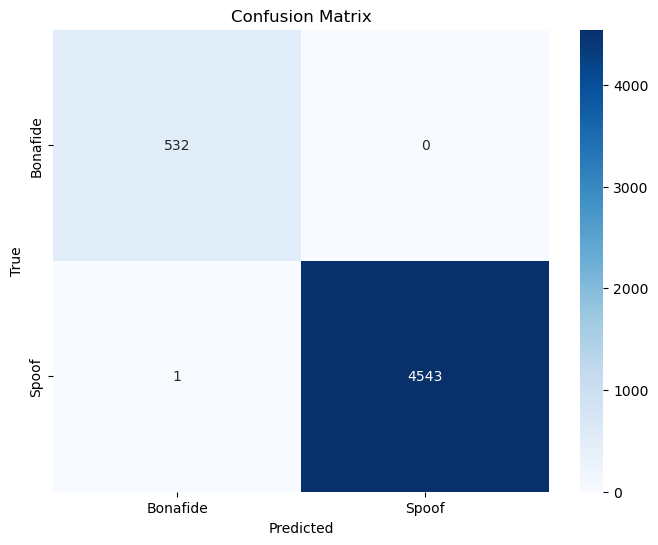

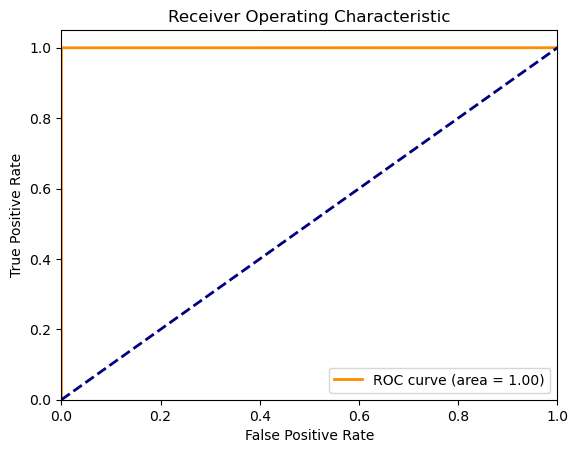

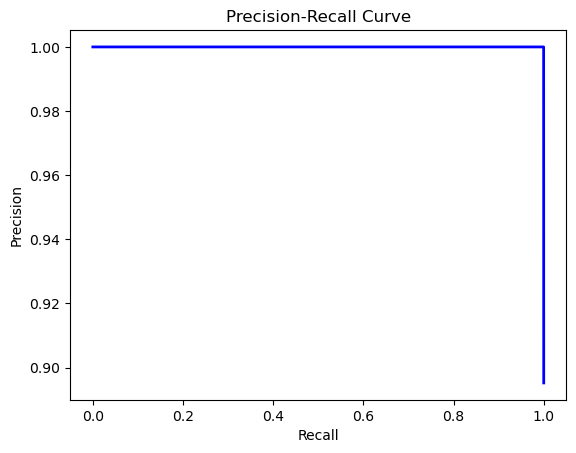

In [40]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import tqdm



def plot_roc_curve(labels, preds):
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(labels, preds):
    precision, recall, _ = precision_recall_curve(labels, preds)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Define val_dataset by splitting full_dataset
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_labels, test_preds)
    test_auc = roc_auc_score(test_labels, test_preds)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test AUC: {test_auc:.4f}')

    return test_loss, test_acc, test_auc, test_preds, test_labels

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def main():
    print("Starting ASVspoof detection process...")
   
    try:
        # Set the root directory for the dataset
        dataset_root = "C:\\Users\\yeshw\\Downloads\\asvspoof\\LA\\LA"
        print(f"Dataset root: {dataset_root}")
     
        # Set the paths to your ASVspoof 2019 dataset
        train_dir = os.path.join(dataset_root, "ASVspoof2019_LA_train", "flac")
        protocol_file = os.path.join(dataset_root, "ASVspoof2019_LA_cm_protocols", "ASVspoof2019.LA.cm.train.trn.txt")
       
        print(f"Train directory: {train_dir}")
        print(f"Protocol file: {protocol_file}")
       
        # Check contents of train_dir
        print(f"Contents of train directory: {os.listdir(train_dir)[:10]}...")  # Print first 10 items
       
        # Create datasets and dataloaders
        print("Creating dataset and applying transformations...")
        transform = AudioTransform(sr=16000)
        full_dataset = ASVspoofDataset(train_dir, protocol_file, transform=transform)
       
        print(f"Total samples in dataset: {len(full_dataset)}")
       
        # Visualize a sample
        sample_audio, sample_label = full_dataset[0]
        print(f"Sample audio shape: {sample_audio.shape}")
        print(f"Sample label: {'Spoof' if sample_label == 1 else 'Bonafide'}")
   
        # Split the dataset
        print("Splitting dataset into train and validation sets...")
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
   
        print(f"Train set size: {len(train_dataset)}")
        print(f"Validation set size: {len(val_dataset)}")
   
        # Create data loaders
        print("Creating data loaders...")
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
   
        # Initialize model
        print("Initializing model...")
        model = ASVResNet(num_classes=2)
        print(model)
   
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
   
        # Check CUDA availability
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
   
        if torch.cuda.is_available():
            print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
            print(f"CUDA Version: {torch.version.cuda}")
   
        # Move model to device
        model = model.to(device)
       
        # Load the best model
        checkpoint_path = 'best_asvspoof_model.pth'
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Evaluate the model
        test_loss, test_acc, test_auc, test_preds, test_labels = evaluate_model(model, val_loader, criterion, device)
        
        # Visualize metrics
        print("Visualizing metrics...")
        plot_confusion_matrix(test_labels, test_preds, classes=['Bonafide', 'Spoof'])
        plot_roc_curve(test_labels, test_preds)
        plot_precision_recall_curve(test_labels, test_preds)
        
    except FileNotFoundError as e:
        print(f"Error: File not found. Please check your dataset paths. Details: {e}")
    except PermissionError as e:
        print(f"Error: Permission denied. Please check your file permissions. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print("Please check your code and data, and try again.")

if __name__ == "__main__":
    main()


In [47]:
def predict_single_file(model, file_path, transform, device):
    model.eval()
    try:
        audio, sr = librosa.load(file_path, sr=16000, duration=3)  # Load up to 3 seconds
        if len(audio) < sr * 3:
            audio = np.pad(audio, (0, sr * 3 - len(audio)), mode='constant')
        
        audio = transform(audio).unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        with torch.no_grad():
            output = model(audio)
            _, predicted = torch.max(output, 1)
            label = 'Spoof' if predicted.item() == 1 else 'Bonafide'
        
        print(f"Prediction for {file_path}: {label}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Path to the new audio file
new_file_path = "C:\\Users\\yeshw\\Downloads\\asvspoof\\LA\\LA\\ASVspoof2019_LA_dev\\flac\\LA_D_1000265.flac"

# Load the best model
checkpoint_path = 'best_asvspoof_model.pth'
checkpoint = torch.load(checkpoint_path)
model = ASVResNet(num_classes=2)
model.load_state_dict(checkpoint['model_state_dict'])

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define transform
transform = AudioTransform(sr=16000)

# Predict the new file
predict_single_file(model, new_file_path, transform, device)

Prediction for C:\Users\yeshw\Downloads\asvspoof\LA\LA\ASVspoof2019_LA_dev\flac\LA_D_1000265.flac: Spoof
